## Simulate Null Hypothesis
**permutation sampling** is a great way to simulate the hypothesis that two variables have identical probability distributions. This is often a hypothesis you want to test, so in this exercise, you will write a function to generate a permutation sample from two data sets.

Remember, a permutation sample of two arrays having respectively n1 and n2 entries is constructed by concatenating the arrays together, scrambling the contents of the concatenated array, and then taking the first n1 entries as the permutation sample of the first array and the last n2 entries as the permutation sample of the second array.

In [ ]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

### Visualizing permutation sampling

To help see how permutation sampling works, in this exercise you will generate permutation samples and look at them graphically.

We will use the Sheffield Weather Station data again, this time considering the monthly rainfall in June (a dry month) and November (a wet month). We expect these might be differently distributed, so we will take permutation samples to see how their ECDFs would look if they were identically distributed.

The data are stored in the NumPy arrays rain_june and rain_november.

In [ ]:
for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june,rain_november)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_june)
x_2, y_2 = ecdf(rain_november)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('monthly rainfall (mm)')
_ = plt.ylabel('ECDF')
plt.show()

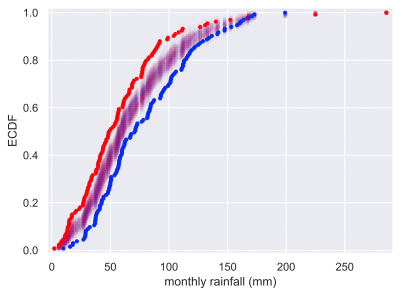Notice that the permutation samples ECDFs overlap and give a purple haze. None of the ECDFs from the permutation samples overlap with the observed data, suggesting that the hypothesis is not commensurate with the data. June and November rainfall are not identically distributed.

#### Generate permutation replicates

In [ ]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)

    return perm_replicates

Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. But, remember, it is important to do EDA first! Let's make a bee swarm plot for the data. They are stored in a pandas DataFrame, df, where column ID is the identity of the frog and column impact_force is the impact force in Newtons (N).

In [ ]:
# Make bee swarm plot
_ = sns.swarmplot(x='ID',y='impact_force',data=df)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()


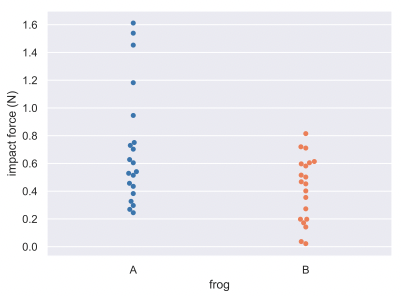

### Permutation test on frog data
The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N. It is possible the frogs strike with the same force and this observed difference was by chance. You will compute the probability of getting at least a 0.29 N difference in mean strike force under the hypothesis that the distributions of strike forces for the two frogs are identical. We use a permutation test with a test statistic of the difference of means to test this hypothesis.

For your convenience, the data has been stored in the arrays force_a and force_b.


In [ ]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a,force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a,force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates>= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

The p-value tells you that there is about a 0.6% chance that you would get the difference of means observed in the experiment if frogs were exactly the same. A p-value below 0.01 is typically said to be "statistically significant," 

### A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

To set up the bootstrap hypothesis test, you will take the mean as our test statistic. Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true. You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. This leaves other properties of Frog B's distribution, such as the variance, unchanged.


In [ ]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b-np.mean(force_b)+0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)


The low p-value suggests that the null hypothesis that Frog B and Frog C have the same mean impact force is false.


#### A two-sample bootstrap hypothesis test for difference of means

We now want to test the hypothesis that Frog A and Frog B have the same mean impact force, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.

In [ ]:
# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b-np.mean(force_b)+mean_force 

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted,np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a-bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates>=(np.mean(force_a)-np.mean(force_b))) / len(bs_replicates)
print('p-value =', p)
